Today we're going to work on a pandas-on-spark project. Note that , the **pyspark.sql.dataframe.Dataframe** type dataframe  and the  **pyspark.pandas.frame.Dataframe** type dataframe is not the same.
In fact , the **pyspark.sql.dataframe.Dataframe** type dataframe is the spark's native dataframe while the second type is a  dataframe which provides a same interface like pandas but  distributed and works on spark.

In this project , we're going to retrieve severals insights about Netflix series throught visualizations using Matplotlib and seaborn. We'll begin with pypsark and after , convert dataframe  on dataframe pandas-on-spark 'cause , pyspark not yet support librairies for visualization like Matplolib and seaborn.

About features we have :
- User ID : the id of the user.
- Subscription Type : we have three type : Premium , Basic . Standard.
- Monthly Revenue : the sum of money by month provided by user's subscription
- Join Date : The date that the users created their account on Netflix.
- Last Payment Date : The last date that users pay their subscription
- Country : The country of residence of the users.
- Age : the age of the users.
- Device : The device used by users to access the Netflix platform.
- Plan duration : The duration of the subscription validity made by the users.


Let's goooo!!!!!!

In [2]:
#install librairies
!pip install pyspark findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=3808541902a553e48ffab54bada01f58ca7d782064d4d1fb4ccd4000a176d98f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
#import librairies
import pyspark
import findspark
from pyspark.sql.functions import*
from pyspark.sql import SparkSession
findspark.init()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
#create a sparksession
spark = SparkSession.builder.appName("Netflix-Users-Analysis").master("local[*]").getOrCreate()

In [5]:
#upload data
from google.colab import files
uploaded = files.upload()

Saving Netflix Userbase.csv to Netflix Userbase.csv


In [6]:
#we upload data in csv files
df = spark.read.csv("Netflix Userbase.csv" , inferSchema = True , header = True)
df.show()

+-------+-----------------+---------------+---------+-----------------+--------------+---+------+----------+-------------+
|User ID|Subscription Type|Monthly Revenue|Join Date|Last Payment Date|       Country|Age|Gender|    Device|Plan Duration|
+-------+-----------------+---------------+---------+-----------------+--------------+---+------+----------+-------------+
|      1|            Basic|             10| 15-01-22|         10-06-23| United States| 28|  Male|Smartphone|      1 Month|
|      2|          Premium|             15| 05-09-21|         22-06-23|        Canada| 35|Female|    Tablet|      1 Month|
|      3|         Standard|             12| 28-02-23|         27-06-23|United Kingdom| 42|  Male|  Smart TV|      1 Month|
|      4|         Standard|             12| 10-07-22|         26-06-23|     Australia| 51|Female|    Laptop|      1 Month|
|      5|            Basic|             10| 01-05-23|         28-06-23|       Germany| 33|  Male|Smartphone|      1 Month|
|      6|       

In [7]:
#checking for the dimension of data
print("Lines :",df.count(),  ","  "Columns : " , len(df.columns))

Lines : 2500 ,Columns :  10


In [8]:
#checking for the schema
df.printSchema()

root
 |-- User ID: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Monthly Revenue: integer (nullable = true)
 |-- Join Date: string (nullable = true)
 |-- Last Payment Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Device: string (nullable = true)
 |-- Plan Duration: string (nullable = true)



In [9]:
#checking for the type of dataframe
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
#checking for data types
df.dtypes

[('User ID', 'int'),
 ('Subscription Type', 'string'),
 ('Monthly Revenue', 'int'),
 ('Join Date', 'string'),
 ('Last Payment Date', 'string'),
 ('Country', 'string'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Device', 'string'),
 ('Plan Duration', 'string')]

In [11]:
#checking for duplicates values
s = df.groupBy(df.columns).count().where("count > 1")
print("Duplicates values : " , s.count())

Duplicates values :  0


In [12]:
#Checking for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)). alias(c) for c in df.columns]).show()

+-------+-----------------+---------------+---------+-----------------+-------+---+------+------+-------------+
|User ID|Subscription Type|Monthly Revenue|Join Date|Last Payment Date|Country|Age|Gender|Device|Plan Duration|
+-------+-----------------+---------------+---------+-----------------+-------+---+------+------+-------------+
|      0|                0|              0|        0|                0|      0|  0|     0|     0|            0|
+-------+-----------------+---------------+---------+-----------------+-------+---+------+------+-------------+



In [13]:
from pyspark.sql.types import DateType
df = df.withColumn("Last Payment Date" , to_date(df["Last Payment Date"] , "dd-MM-yy").cast(DateType()))
df = df.withColumn("Join Date" , to_date(df["Join Date"] , "dd-MM-yy").cast(DateType()))
df.dtypes

[('User ID', 'int'),
 ('Subscription Type', 'string'),
 ('Monthly Revenue', 'int'),
 ('Join Date', 'date'),
 ('Last Payment Date', 'date'),
 ('Country', 'string'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Device', 'string'),
 ('Plan Duration', 'string')]

In [14]:
#checking for the statistics
df.describe().show()

+-------+-----------------+-----------------+------------------+-------------+-----------------+------+------+-------------+
|summary|          User ID|Subscription Type|   Monthly Revenue|      Country|              Age|Gender|Device|Plan Duration|
+-------+-----------------+-----------------+------------------+-------------+-----------------+------+------+-------------+
|  count|             2500|             2500|              2500|         2500|             2500|  2500|  2500|         2500|
|   mean|           1250.5|             NULL|           12.5084|         NULL|          38.7956|  NULL|  NULL|         NULL|
| stddev|721.8321596234589|             NULL|1.6868513944775387|         NULL|7.171777631644684|  NULL|  NULL|         NULL|
|    min|                1|            Basic|                10|    Australia|               26|Female|Laptop|      1 Month|
|    max|             2500|         Standard|                15|United States|               51|  Male|Tablet|      1 Month|


Our data is ready to visualize!!! Let's convert  dataframe pyspark , on dataframe pandas-on-spark.

In [15]:
import pyspark.pandas as ps
pop = ps.DataFrame(df)
pop

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month
5,6,Premium,15,2022-03-18,2023-06-27,France,29,Female,Smart TV,1 Month
6,7,Standard,12,2021-12-09,2023-06-25,Brazil,46,Male,Tablet,1 Month
7,8,Basic,10,2023-04-02,2023-06-24,Mexico,39,Female,Laptop,1 Month
8,9,Standard,12,2022-10-20,2023-06-23,Spain,37,Male,Smartphone,1 Month
9,10,Premium,15,2023-01-07,2023-06-22,Italy,44,Female,Smart TV,1 Month


In [16]:
#Set the User ID as the index column
pop = pop.set_index("User ID")
pop

,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
User ID,,,,,,,,,
1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month
2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month
3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month
4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month
5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month
6,Premium,15,2022-03-18,2023-06-27,France,29,Female,Smart TV,1 Month
7,Standard,12,2021-12-09,2023-06-25,Brazil,46,Male,Tablet,1 Month
8,Basic,10,2023-04-02,2023-06-24,Mexico,39,Female,Laptop,1 Month
9,Standard,12,2022-10-20,2023-06-23,Spain,37,Male,Smartphone,1 Month


In [17]:
#the fist five rows
pop.head(5)

,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
User ID,,,,,,,,,
1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month
2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month
3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart TV,1 Month
4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month
5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month


In [18]:
type(pop)

pyspark.pandas.frame.DataFrame

In [19]:
#checking for the data types of the dataframe
pop.dtypes

,0
Subscription Type,object
Monthly Revenue,int32
Join Date,object
Last Payment Date,object
Country,object
Age,int32
Gender,object
Device,object
Plan Duration,object


In [20]:
pop['Last Payment Date'] = ps.to_datetime(pop['Last Payment Date'], format='%d-%m-%y')
pop['Join Date'] = ps.to_datetime(pop['Join Date'], format='%d-%m-%y')
pop.dtypes

,0
Subscription Type,object
Monthly Revenue,int32
Join Date,datetime64
Last Payment Date,datetime64
Country,object
Age,int32
Gender,object
Device,object
Plan Duration,object


Let's query our data by visualization.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Figure size 1500x600 with 0 Axes>

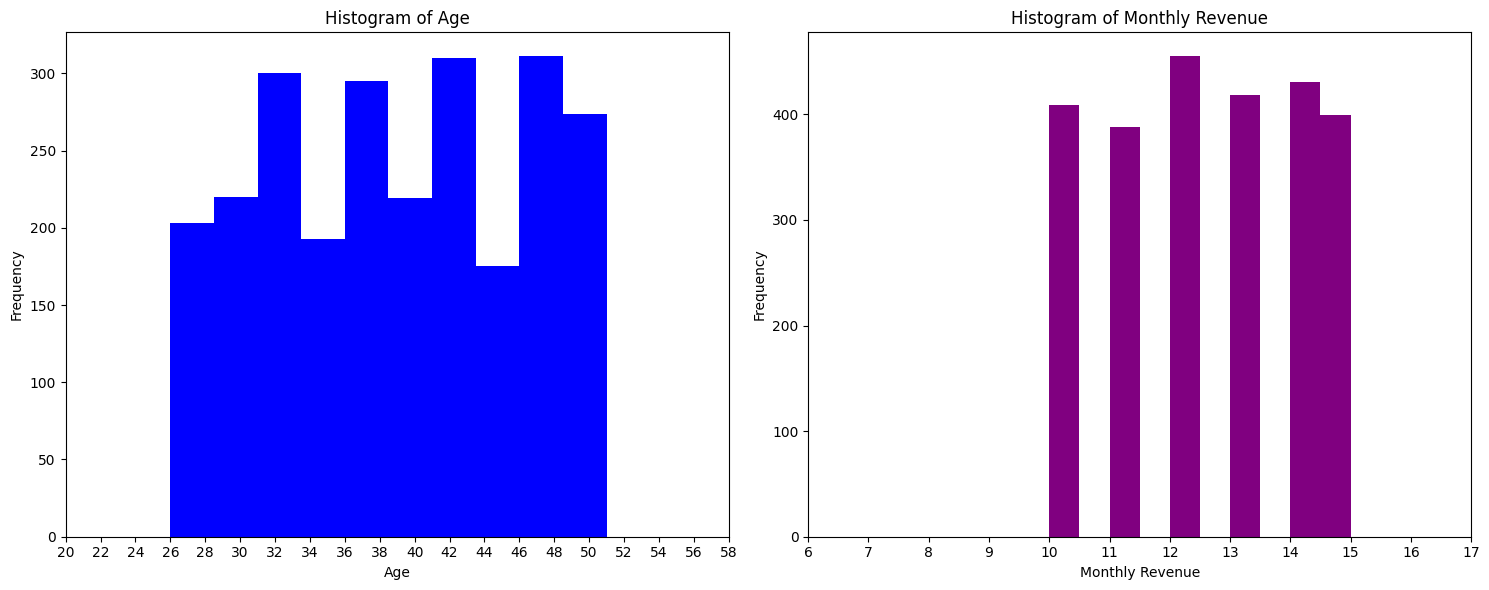

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# first sub-histogram for ags
axes[0].hist(pop["Age"].to_numpy(), color="blue")
axes[0].set_title("Histogram of Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks(range(20, 60, 2))

# second sub-histogram for the monthly revenu
axes[1].hist(pop["Monthly Revenue"].to_numpy(), color="purple")
axes[1].set_title("Histogram of Monthly Revenue")
axes[1].set_xlabel("Monthly Revenue")
axes[1].set_ylabel("Frequency")
axes[1].set_xticks(range(6, 18, 1))

plt.tight_layout()
plt.show()

More than 300 people is between 46 and 48 years old ,and more than 400 monthly revenu are about 12.

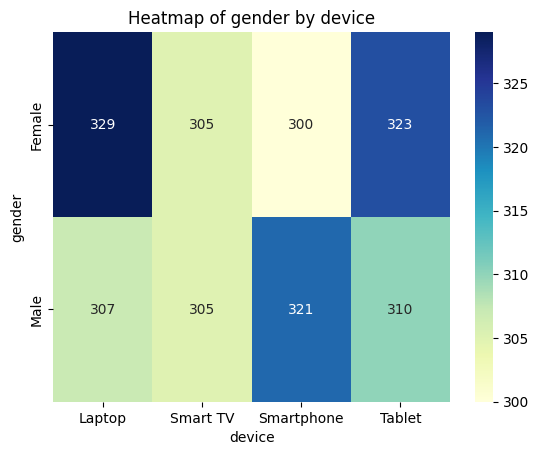

In [22]:
# contengency table between genders and devices
contingency_table = pd.crosstab(pop['Gender'].to_numpy(), pop['Device'].to_numpy())

# Afficher le heatmap
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.xlabel('device')
plt.ylabel('gender')
plt.title('Heatmap of gender by device')
plt.show()

329 females watch series/movies on laptop and 323 on tablet , while 321 of males watch their own on smartphone , crosstab is overly fascinating!!!

In [23]:
Nb_gender = pop["Gender"].value_counts().to_pandas()
Nb_gender

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,Gender
Female,1257
Male,1243


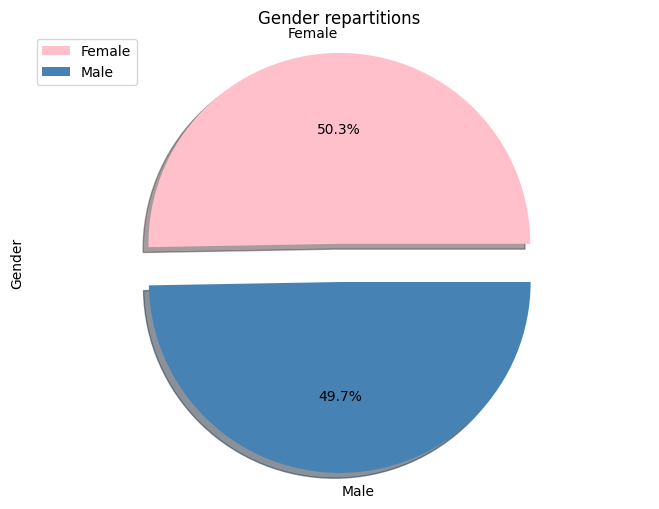

In [24]:
# Diagramme en secteurs
plt.figure(figsize=(8, 6))
myexplode = [0.2,0]
Nb_gender.plot(kind='pie', colors=['pink', 'steelblue'], autopct='%1.1f%%' , explode = myexplode, shadow = True)
plt.title("Gender repartitions")
plt.axis('equal')
plt.legend(Nb_gender.index, loc='upper left')
plt.show()

There's more female than male!!! yeeaahhhh!!!!

In [25]:
country = pop["Country"].value_counts()
country

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


United States     451
Spain             451
Canada            317
Germany           183
France            183
Italy             183
Mexico            183
Brazil            183
Australia         183
United Kingdom    183
Name: Country, dtype: int64

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: >

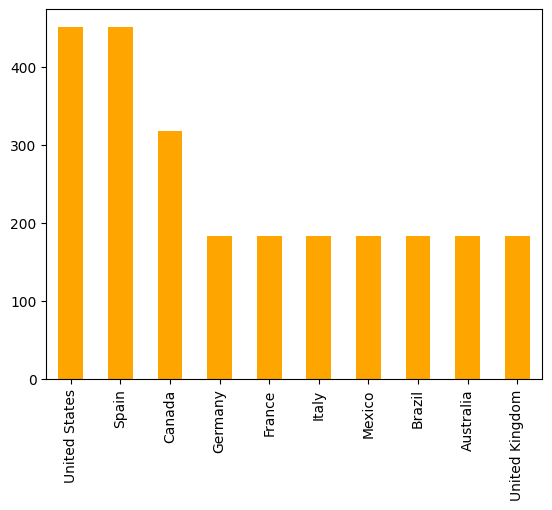

In [26]:
result = country.to_pandas()
sol = result.plot(kind = "bar" , color = "orange")
sol

Again and always USA , but with Spain this time , are the country with more Netfilx subscribers , but let's check the repartion about gender in each country..

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


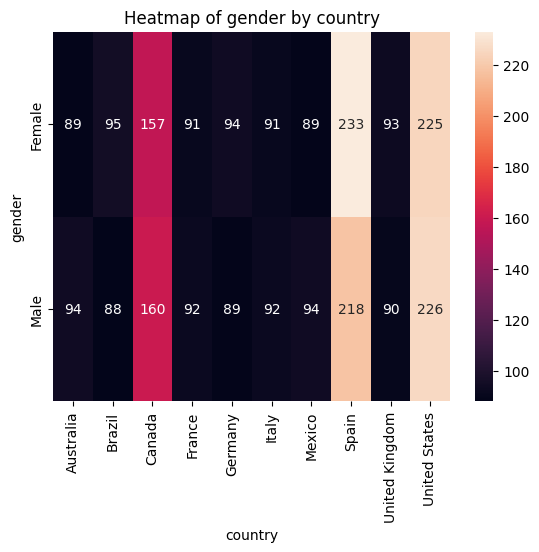

In [27]:
# contengency table between Gender and devices
contingency_table = pd.crosstab(pop['Gender'].to_numpy(), pop['Country'].to_numpy())

# Afficher le heatmap
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.xlabel('country')
plt.ylabel('gender')
plt.title('Heatmap of gender by country')
plt.show()

In spain , there are more female than male and in USA , there are more male than female(just one more male compared with female.)

In [28]:
Nb_souscription = pop["Subscription Type"].value_counts().to_pandas()
Nb_souscription

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,Subscription Type
Basic,999
Standard,768
Premium,733


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:893: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


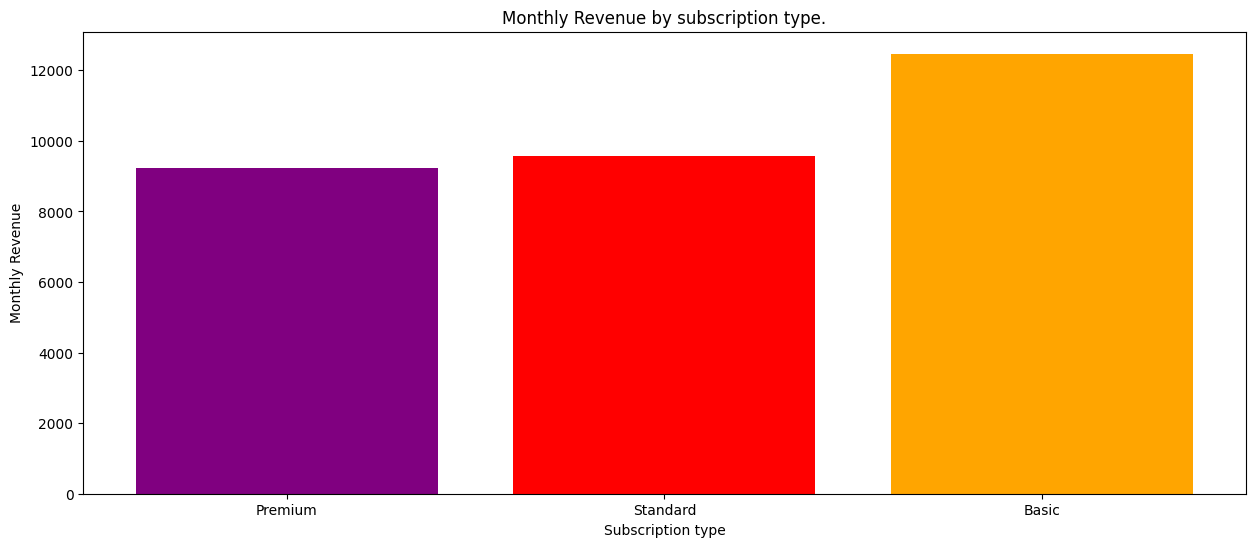

In [29]:
result = pop.groupby("Subscription Type")["Monthly Revenue"].sum().sort_values(ascending = True)
data = result.to_pandas()
plt.figure(figsize = (15 , 6))
mycolors = ["purple" , "red" , "orange"]
plt.bar(data.index , data.values , color = mycolors)
plt.title("Monthly Revenue by subscription type.")
plt.xlabel("Subscription type")
plt.ylabel("Monthly Revenue")
plt.show()

The Basic subscription is the best. It's provides an important monthly revenue than the others.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


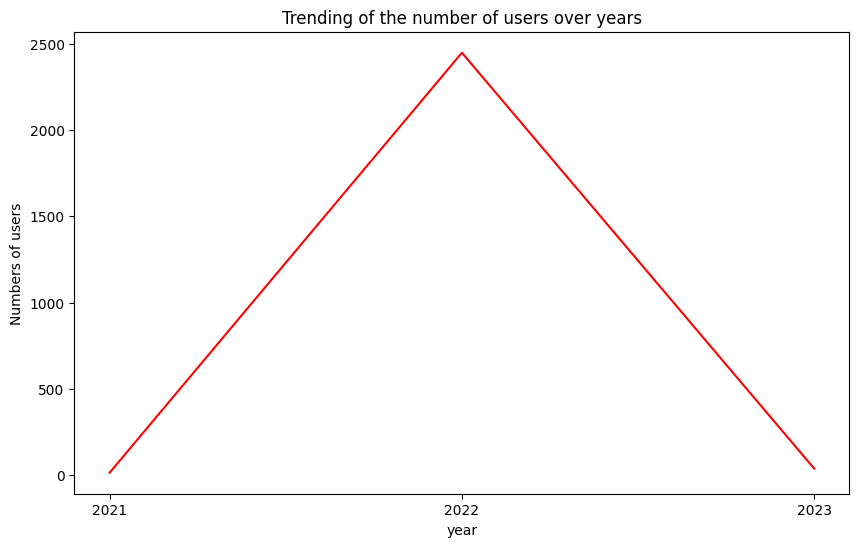

In [30]:
pop["join_year"] = pop["Join Date"].dt.year #here we extract years
data = pop["join_year"].value_counts().to_pandas()
plt.figure(figsize=(10,6))
sns.lineplot(x=data.index, y=data.values , color = "red")
plt.xticks(data.index.round().astype(int))
plt.title('Trending of the number of users over years')
plt.xlabel('year')
plt.ylabel('Numbers of users')
plt.show()

2022 was the best years for Netflix platform , it's received more than 2000 of users.

In [105]:
pop["date_last_pay"] = pop["Last Payment Date"].dt.year #extraction des annees
result = pop["date_last_pay"].value_counts().to_pandas()
result

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning:

The resulting Series will have a fixed name of 'count' from 4.0.0.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



,date_last_pay
2023,2500


In [103]:
pop["month_last_pay"] = pop["Last Payment Date"].dt.month #extraction des annees
s = pop["month_last_pay"].value_counts().to_pandas()
s

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning:

The resulting Series will have a fixed name of 'count' from 4.0.0.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



,month_last_pay
7,1634
6,866


All users paid their subscription on 2023 , but most paid on July.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning:

The resulting Series will have a fixed name of 'count' from 4.0.0.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



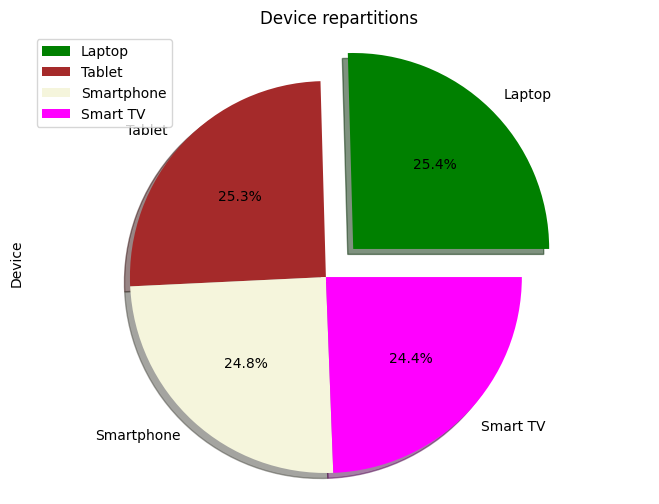

In [78]:
Nb_device = pop["Device"].value_counts().to_pandas()
plt.figure(figsize=(8, 6))
myexplode = [0.2,0,0,0]
Nb_device .plot(kind='pie', colors=["green", "brown" , "beige" , "magenta"], autopct='%1.1f%%' , explode = myexplode, shadow = True)
plt.title("Device repartitions")
plt.axis('equal')
plt.legend(Nb_device.index, loc='upper left')
plt.show()

Just amazing....most users use a Laptop to connect on the Netflix platform.